# Hybrid LSTM-GRU Model Training & Robustness Testing

This notebook trains the **Hybrid LSTM-GRU** model on **Real WESAD (S2)** data (exactly matching the Web App) and performs robustness tests.

## 1. Objectives
*   **Train:** Hybrid LSTM-GRU on Raw ECG/EDA with **Noise Augmentation**.
*   **Evaluate:** Accuracy, F1-Score, Confusion Matrix.
*   **Robustness Test:** Evaluate performance under noisy conditions (simulating real-world sensor noise).
*   **Optimization:** Uses **Early Stopping** to determine the optimal number of epochs.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

## 2. Load Real WESAD Data

In [23]:
DATA_PATH = '../../datasets/WESAD/S2/S2.pkl'

print(f"Loading {DATA_PATH}...")
with open(DATA_PATH, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Preprocessing (Same as Web App)
ecg = data['signal']['chest']['ECG'].flatten()
eda = data['signal']['chest']['EDA'].flatten()
labels = data['label']

# Normalize
ecg = (ecg - np.mean(ecg)) / (np.std(ecg) + 1e-6)
eda = (eda - np.mean(eda)) / (np.std(eda) + 1e-6)

# Filter Baseline(1) vs Stress(2)
mask = np.isin(labels, [1, 2])
ecg = ecg[mask]
eda = eda[mask]
y = labels[mask]
y = np.where(y == 2, 1, 0).astype(np.float32) # 1=Stress

print(f"Total Samples: {len(y)}")

Loading ../../datasets/WESAD/S2/S2.pkl...
Total Samples: 1231300


## 3. Create Sequences

In [24]:
SEQUENCE_LENGTH = 60

def create_sequences(ecg, eda, y, seq_len, step=100):
    xs, ys = [], []
    for i in range(0, len(ecg) - seq_len, step):
        xs.append(np.column_stack((ecg[i:i+seq_len], eda[i:i+seq_len])))
        ys.append(y[i+seq_len-1])
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X, Y = create_sequences(ecg, eda, y, SEQUENCE_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=32)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (9850, 60, 2), Test Shape: (2463, 60, 2)


## 4. Define Hybrid LSTM-GRU Model

In [25]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        # Lightweight architecture for Web Compatibility
        self.lstm = nn.LSTM(input_size=2, hidden_size=32, batch_first=True)
        self.gru = nn.GRU(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

model = HybridModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

## 5. Train Model with Early Stopping + Noise Augmentation
Optimizing epoch count by stopping when validation loss plateaus.
**NEW**: Adding random Gaussian noise during training to improve robustness.

Training with Early Stopping + Noise Augmentation (σ=0.1)...
Epoch 1: Train Loss=0.6143, Val Loss=0.5411
Epoch 2: Train Loss=0.5268, Val Loss=0.4856
Epoch 3: Train Loss=0.5001, Val Loss=0.4823
Epoch 4: Train Loss=0.4769, Val Loss=0.4299
Epoch 5: Train Loss=0.4470, Val Loss=0.4051
Epoch 6: Train Loss=0.4262, Val Loss=0.3910
Epoch 7: Train Loss=0.4113, Val Loss=0.3893
Epoch 8: Train Loss=0.3993, Val Loss=0.3807
Epoch 9: Train Loss=0.3931, Val Loss=0.3634
Epoch 10: Train Loss=0.3858, Val Loss=0.3692
Epoch 11: Train Loss=0.3734, Val Loss=0.3821
Epoch 12: Train Loss=0.3685, Val Loss=0.3529
Epoch 13: Train Loss=0.3692, Val Loss=0.3401
Epoch 14: Train Loss=0.3561, Val Loss=0.3526
Epoch 15: Train Loss=0.3517, Val Loss=0.3162
Epoch 16: Train Loss=0.3448, Val Loss=0.3256
Epoch 17: Train Loss=0.3392, Val Loss=0.3321
Epoch 18: Train Loss=0.3294, Val Loss=0.3156
Epoch 19: Train Loss=0.3237, Val Loss=0.3386
Epoch 20: Train Loss=0.3206, Val Loss=0.3484
Epoch 21: Train Loss=0.3185, Val Loss=0.3073
Epo

C:\Users\priya\AppData\Local\Temp\ipykernel_18916\3455904593.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_robust.pth'))


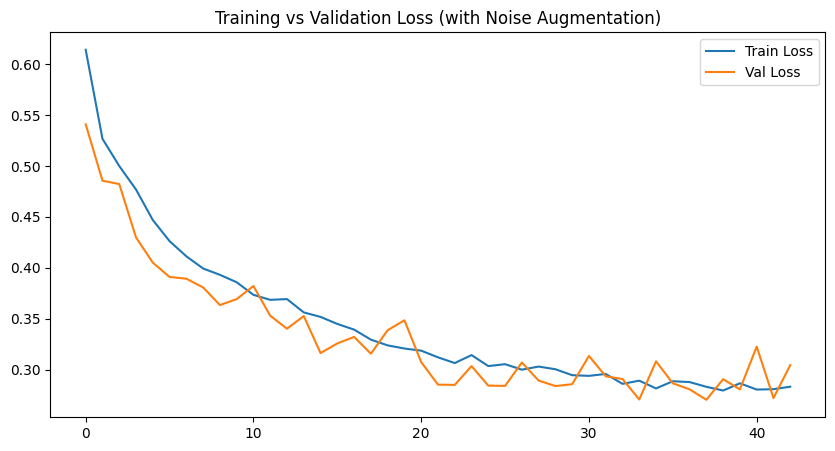

In [26]:
EPOCHS = 50
patience = 5
best_loss = float('inf')
trigger_times = 0
NOISE_LEVEL = 0.1  # Add 10% noise during training

loss_history = []
val_loss_history = []

print(f"Training with Early Stopping + Noise Augmentation (σ={NOISE_LEVEL})...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Add Gaussian noise for augmentation
        noise = torch.randn_like(inputs) * NOISE_LEVEL
        noisy_inputs = inputs + noise
        
        optimizer.zero_grad()
        outputs = model(noisy_inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation Loop (no noise)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    
    # Early Stopping Check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model_robust.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at Epoch {epoch+1}!")
            break

# Restore Best Weights
model.load_state_dict(torch.load('best_model_robust.pth'))

# Plot Curves
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Training vs Validation Loss (with Noise Augmentation)")
plt.legend()
plt.show()

## 6. Robustness Test: Noise Injection
Evaluating how the model handles noisy sensor data (Gaussian Noise).

Robustness Results (After Noise Augmentation Training):
Noise Level 0.0: Accuracy = 0.8896
Noise Level 0.1: Accuracy = 0.8782
Noise Level 0.2: Accuracy = 0.7093
Noise Level 0.5: Accuracy = 0.5432
Noise Level 1.0: Accuracy = 0.5615


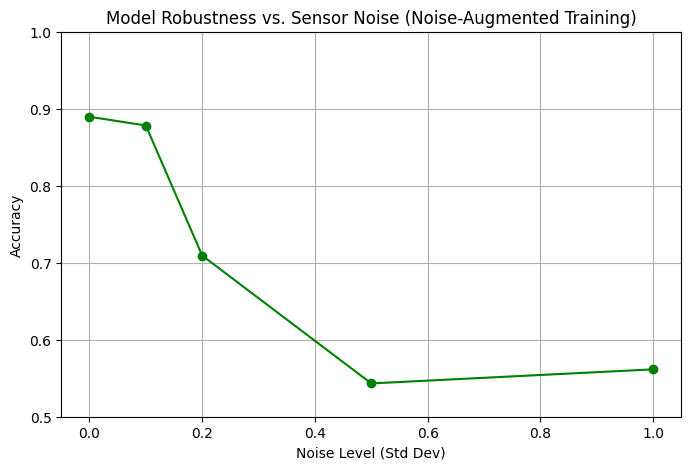

In [27]:
def evaluate_with_noise(model, loader, noise_level=0.0):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            # Add Gaussian Noise
            if noise_level > 0:
                noise = torch.randn_like(inputs) * noise_level
                inputs = inputs + noise
            
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Test at different noise levels
noise_levels = [0.0, 0.1, 0.2, 0.5, 1.0]
accuracies = []

print("Robustness Results (After Noise Augmentation Training):")
for nl in noise_levels:
    acc = evaluate_with_noise(model, test_loader, nl)
    accuracies.append(acc)
    print(f"Noise Level {nl}: Accuracy = {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(noise_levels, accuracies, marker='o', color='green')
plt.title("Model Robustness vs. Sensor Noise (Noise-Augmented Training)")
plt.xlabel("Noise Level (Std Dev)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()